Name: `YOUR NAME`

Student ID: `YOUR STUDENT ID`

# Clustering with EM (GMM) and DBSCAN

In this notebook, you will explore two major unsupervised clustering techniques:

- **Expectation-Maximization (EM) with Gaussian Mixture Models (GMM)**
- **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

You will:
- Implement simplified versions from scratch
- Compare them with `scikit-learn` implementations
- Visualize and interpret the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN as SK_DBSCAN

## EM Algorithm Intuition

The **Expectation-Maximization (EM)** algorithm is used to estimate the parameters of probabilistic models with latent variables. In the context of GMM, we assume the data is generated from a mixture of Gaussians.

The process iteratively:
1. **E-step**: Estimate the responsibilities (probability of each data point belonging to each component).
2. **M-step**: Update the parameters (means, variances, weights) using those responsibilities.

In this part, you will implement EM from scratch on 1D data.

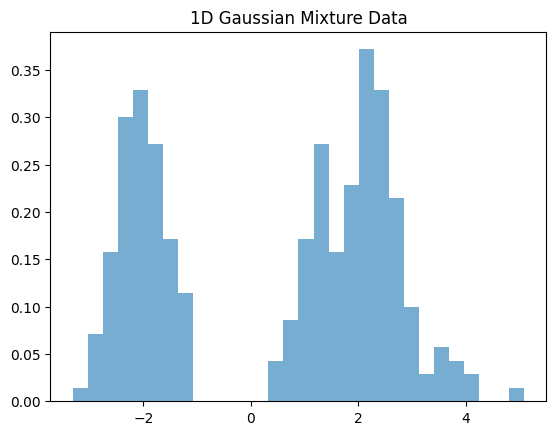

In [ ]:
# Generate synthetic 1D Gaussian mixture data
np.random.seed(42)
data = np.hstack([
    np.random.normal(loc=-2, scale=0.5, size=100),
    np.random.normal(loc=2, scale=0.8, size=150)
]).reshape(-1, 1)

# Visualize data
plt.hist(data, bins=30, density=True, alpha=0.6)
plt.title("1D Gaussian Mixture Data")
plt.show()

In [ ]:
# Initialize parameters
k = 2  # number of components
means = np.random.choice(data.flatten(), k)
variances = np.ones(k)
weights = np.ones(k) / k

# Define Gaussian PDF
def gaussian(x, mean, var):
    return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean)**2 / (2 * var))

# EM Algorithm
log_likelihoods = []
for iteration in range(20):
    # E-step
    resp = np.zeros((len(data), k))
    for i in range(k):
        resp[:, i] = weights[i] * gaussian(data.flatten(), means[i], variances[i])
    resp /= resp.sum(axis=1, keepdims=True)

    # M-step
    Nk = resp.sum(axis=0)
    for i in range(k):
        means[i] = (resp[:, i] @ data.flatten()) / Nk[i]
        variances[i] = ((resp[:, i] * (data.flatten() - means[i])**2).sum()) / Nk[i]
        weights[i] = Nk[i] / len(data)

    # Log-likelihood
    ll = np.sum(np.log((resp * np.array([gaussian(data.flatten(), m, v) for m, v in zip(means, variances)]).T).sum(axis=1)))
    log_likelihoods.append(ll)

In [ ]:
# Plot log-likelihood
plt.plot(log_likelihoods)
plt.title("Log-Likelihood over EM Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

In [ ]:
# Show final cluster assignments
final_resp = np.zeros((len(data), k))
for i in range(k):
    final_resp[:, i] = weights[i] * gaussian(data.flatten(), means[i], variances[i])
final_labels = np.argmax(final_resp, axis=1)
plt.scatter(data, np.zeros_like(data), c=final_labels, cmap='tab10')
plt.title("GMM Clustering (from scratch)")
plt.show()


## Comparison: GMM with scikit-learn

Now, we'll use `sklearn.mixture.GaussianMixture` to model the same data.
This helps validate our implementation and also exposes us to standard tools used in real-world machine learning.

In [ ]:
# Fit GMM using scikit-learn
model = GaussianMixture(n_components=2, random_state=42)
model.fit(data)
labels = model.predict(data)

# Show model parameters
print("Means:", model.means_.flatten())
print("Weights:", model.weights_)
print("Covariances:", model.covariances_.flatten())

Means: [-2.05201454  2.051918  ]
Weights: [0.39995656 0.60004344]
Covariances: [0.20407461 0.63652495]


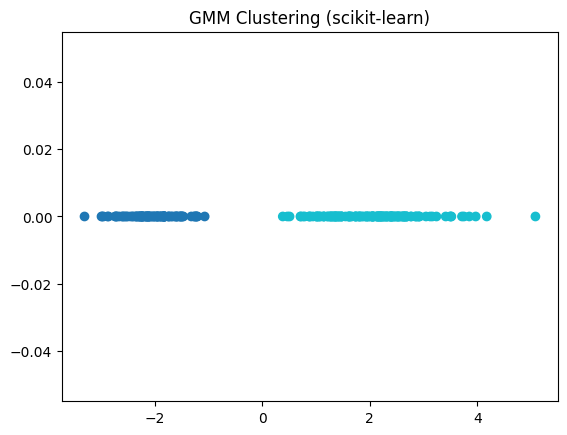

In [ ]:
# Plot GMM Clustering
plt.scatter(data, np.zeros_like(data), c=labels, cmap='tab10')
plt.title("GMM Clustering (scikit-learn)")
plt.show()

## DBSCAN Algorithm Overview

**DBSCAN** is a density-based clustering algorithm that groups together points that are closely packed, and marks points that lie alone in low-density regions as noise.

In this section, you'll implement DBSCAN from scratch.

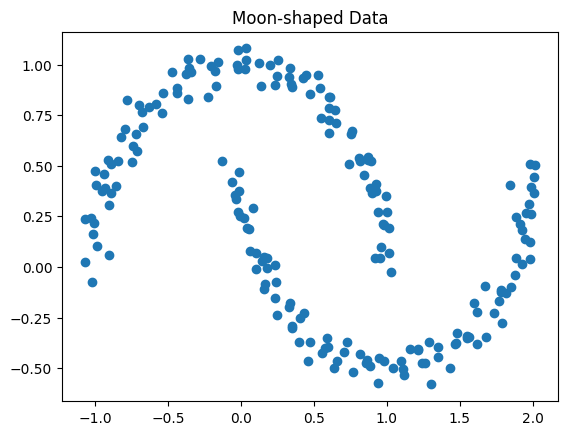

In [ ]:
# Generate 2D moon-shaped data
X, _ = make_moons(n_samples=200, noise=0.05, random_state=0)

# Visualize data
plt.scatter(X[:, 0], X[:, 1])
plt.title("Moon-shaped Data")
plt.show()

In [ ]:
# DBSCAN implementation from scratch
def dbscan(X, eps, min_pts):
    labels = np.full(len(X), -1)
    cluster_id = 0

    def region_query(point_idx):
        return [i for i, x in enumerate(X)
                if np.linalg.norm(X[point_idx] - x) < eps]

    def expand_cluster(point_idx, neighbors):
        nonlocal cluster_id
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            n_idx = neighbors[i]
            if labels[n_idx] == -1:
                labels[n_idx] = cluster_id
                n_neighbors = region_query(n_idx)
                if len(n_neighbors) >= min_pts:
                    neighbors += [n for n in n_neighbors if n not in neighbors]
            i += 1

    for i in range(len(X)):
        if labels[i] != -1:
            continue
        neighbors = region_query(i)
        if len(neighbors) < min_pts:
            labels[i] = -1  # noise
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels

In [ ]:
# Run DBSCAN from scratch
labels_scratch = dbscan(X, eps=0.2, min_pts=5)

# Plot DBSCAN from scratch
plt.scatter(X[:, 0], X[:, 1], c=labels_scratch, cmap='tab10')
plt.title("DBSCAN from Scratch")
plt.show()

## Comparison: DBSCAN with scikit-learn

Here, we use `sklearn.cluster.DBSCAN` to cluster the same moon-shaped data. Again, this serves as a benchmark for your scratch version.


In [ ]:
# Run DBSCAN using scikit-learn
db = SK_DBSCAN(eps=0.2, min_samples=5)
labels_lib = db.fit_predict(X)

In [ ]:
# Show number of clusters and noise
n_clusters = len(set(labels_lib)) - (1 if -1 in labels_lib else 0)
n_noise = list(labels_lib).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


Estimated number of clusters: 2
Estimated number of noise points: 0


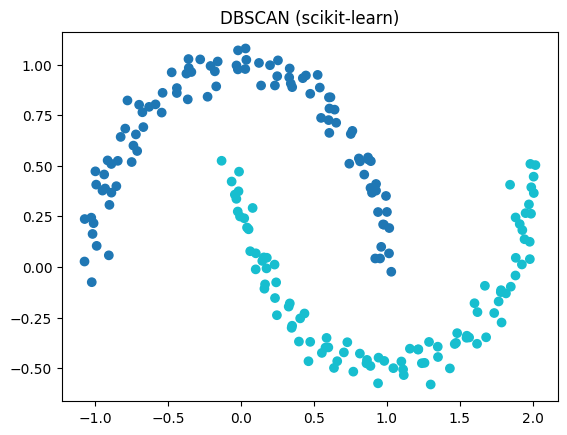

In [ ]:
# Plot DBSCAN result
plt.scatter(X[:, 0], X[:, 1], c=labels_lib, cmap='tab10')
plt.title("DBSCAN (scikit-learn)")
plt.show()
